In [1]:
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader, Subset
from utils.data import COCOAEDataset, collate_fn
from utils.transforms import get_transform
from utils.transforms import ResizeTransform
from noise.scheduler import NoiseScheduler, LinearMaskScheduler, mask_image
from models.masked_autoencoder import MaskedAEConfig, MaskedAutoEncoderForPretraining
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

c:\Users\Rodrigo\.conda\envs\dl-final-sp2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = COCOAEDataset(root="coco/images/train2017/",
                        annFile="coco/annotations/ann2017/captions_train2017.json",
                        transform=get_transform(),
                        tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased', cache_dir='cache/'),
                        ignore_cache=False,
                        train=True)

Loading cached annotations...


In [27]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

sample = dataset[0]

noise_scheduler = LinearMaskScheduler(vocab_size=len(dataset.tokenizer), masking_ratio=0.2)
model : MaskedAutoEncoderForPretraining = MaskedAutoEncoderForPretraining(MaskedAEConfig(len(dataset.tokenizer))).to(DEVICE)
distributed_state_dict = torch.load("checkpoints/MAE_simple_54.chkp")

In [28]:
# prune state dict distributed artifacts
keys = list(distributed_state_dict.keys())
for key in keys:
    distributed_state_dict[key[7:]] = distributed_state_dict[key]
    del distributed_state_dict[key]

In [29]:
model.load_state_dict(distributed_state_dict)

<All keys matched successfully>

In [30]:
images, captions = dataset[5]

images = images.unsqueeze(0).to(DEVICE, non_blocking=True)
captions = captions.unsqueeze(0).to(DEVICE, non_blocking=True)

masked_images, masked_text, (ip, rp, tm) = noise_scheduler.get_masked(images, captions, need_masks=True)
reconstructed_images, reconstructed_captions = model.forward(masked_images, masked_text, ip, rp)
   


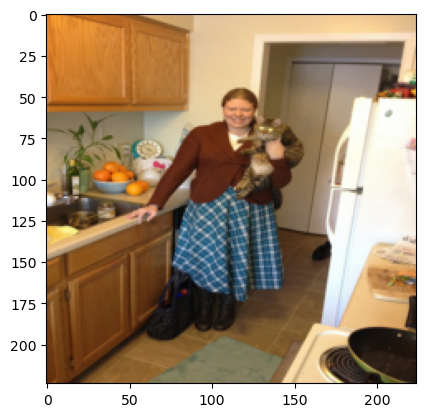

In [32]:
plt.imshow(images[0].permute(1, 2, 0).detach().cpu().numpy())

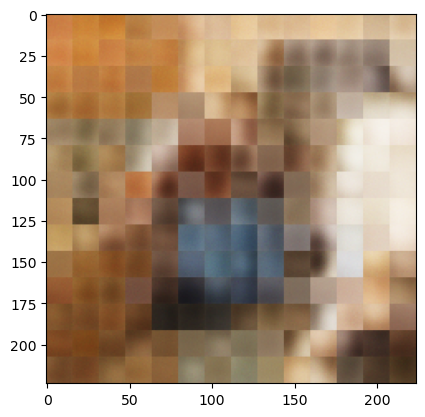

[CLS] a girl smiles as she holds a cat and wears a brightly colored tv. [SEP]


In [33]:
for image in reconstructed_images:
    plt.imshow(image.permute(1, 2, 0).detach().cpu().numpy())
    plt.show()

for caption in reconstructed_captions:
    print(dataset.tokenizer.decode(torch.argmax(caption, dim=-1)))